# CH4 Time Series Forecasting
**Objective**: forecast future atmospheric methane concentration

## Input Data
- 'data/processed/ch4_preprocessed.csv'
- 'data/processed/ch4_preprocessed_logged.csv'

## Model Configuration
- 'results/CH4_full_dataset_best_model_config.json'

## Stages
1. Load the input data
2. load saved model configuration
3. log input data
4. re-fit model with saved parameters
5. static forecast of future CH4 atmospheric concentration

# Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX, SARIMAXResults

# Load the Data

In [8]:
# load the preprocessed train and test data (from ../data/processed/), and explicity set the frequency
CH4_preprocessed = pd.read_csv(
    '../data/processed/ch4_preprocessed.csv',
    parse_dates=['date'], 
    index_col='date'
)

CH4_preprocessed.index = pd.DatetimeIndex(CH4_preprocessed.index, freq='W-SUN')

CH4_preprocessed_logged = pd.read_csv(
    '../data/processed/ch4_preprocessed_logged.csv',
    parse_dates=['date'],
    index_col='date'
)

CH4_preprocessed_logged.index = pd.DatetimeIndex(CH4_preprocessed.index, freq='W-SUN')

In [4]:
CH4_preprocessed.head()

,CH4
date,
1983-05-08,1645.17000
1983-05-15,1650.48025
1983-05-22,1650.48025
1983-05-29,1650.48025
1983-06-05,1638.08600


In [5]:
CH4_preprocessed.tail()

,CH4
date,
2025-03-09,1949.448
2025-03-16,1949.266
2025-03-23,1949.084
2025-03-30,1948.902
2025-04-06,1948.720


In [9]:
CH4_preprocessed_logged.head()

,CH4
date,
1983-05-08,7.405599
1983-05-15,7.408822
1983-05-22,7.408822
1983-05-29,7.408822
1983-06-05,7.401284


In [10]:
CH4_preprocessed_logged.tail()

,CH4
date,
2025-03-09,7.575302
2025-03-16,7.575208
2025-03-23,7.575115
2025-03-30,7.575021
2025-04-06,7.574928


# Load the model configuration and re-fit model

In [11]:
import json

with open('../results/CH4_full_dataset_best_model_config.json', 'r') as f:
    config = json.load(f)

In [13]:
# Rebuild and re-fit model
model = SARIMAX(
    CH4_preprocessed_logged,
    order=config['order'],
    seasonal_order=config['seasonal_order'],
    trend=config.get('trend', 'n'),
    enforce_stationarity=config.get('enforce_stationarity', False),
    enforce_invertibility=config.get('enforce_invertibility', False)
)

CH4_model_results = model.fit(method=config['fit_method'])

print(f"Model re-fitted using data from {config['training_date_range']['start']} to {config['training_date_range']['end']}")

C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model re-fitted using data from 1983-05-08 to 2025-04-06


In [14]:
# verify the model order and seasonal order
print('"CH4_best_sarima": SARIMA(1,1,0)(1,0,2)[52]')
print('Order (p, d, q):', model.order)
print('Seasonal order (P, D, Q, s):', model.seasonal_order)

"CH4_best_sarima": SARIMA(1,1,0)(1,0,2)[52]
Order (p, d, q): (1, 1, 0)
Seasonal order (P, D, Q, s): (1, 0, 2, 52)


# Forecast CH4 concentration for future periods

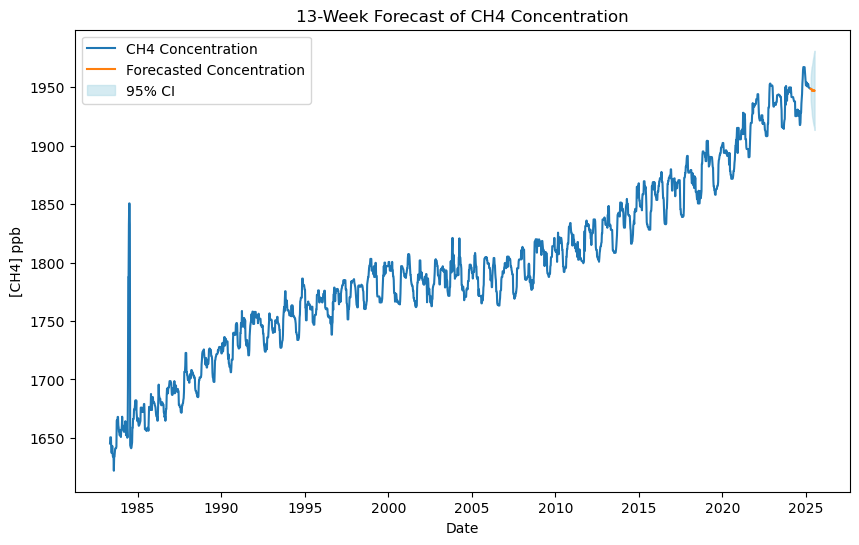

In [15]:
forecast_steps = 13
CH4_forecast = CH4_model_results.get_forecast(steps=forecast_steps)
CH4_forecast_mean = np.exp(CH4_forecast.predicted_mean)
CH4_forecast_conf_int = np.exp(CH4_forecast.conf_int())

CH4_forecast_index = pd.date_range(
    CH4_preprocessed.index[-1],
    periods=forecast_steps + 1,
    freq='W-SUN')[1:]  # Exclude the first date (last date of training set)
    
# plot the forecast results for model 5: ARIMA(1,1,0)(1,0,2)[52]
plt.figure(figsize=(10,6))
plt.plot(CH4_preprocessed.index, CH4_preprocessed, label='CH4 Concentration')
plt.plot(CH4_forecast_index, CH4_forecast_mean, label='Forecasted Concentration')
plt.fill_between(
    CH4_forecast_index, 
    CH4_forecast_conf_int.iloc[:, 0], 
    CH4_forecast_conf_int.iloc[:, 1], 
    color='lightblue', 
    alpha=0.5, 
    label='95% CI'
)
plt.title('13-Week Forecast of CH4 Concentration')
plt.xlabel('Date')
plt.ylabel('[CH4] ppb')
plt.legend()
plt.show()

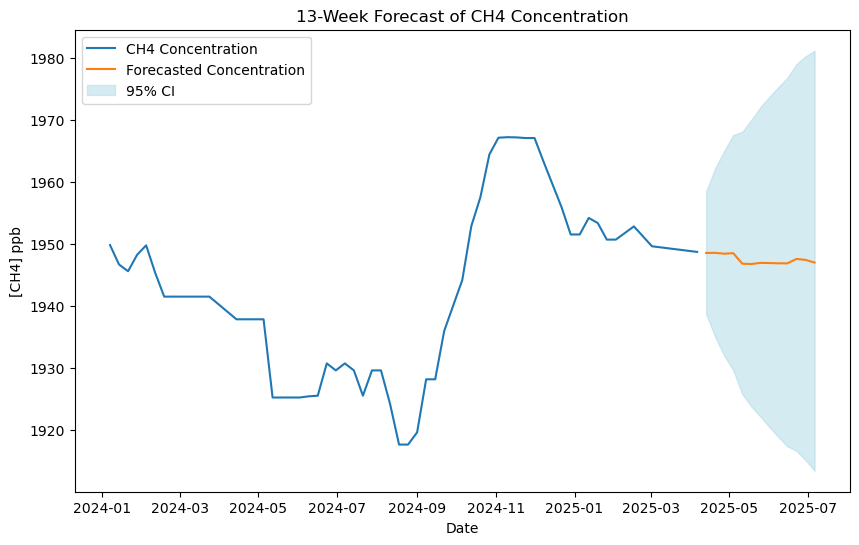

In [16]:
# focus more on the forecast results

cutoff_date = pd.Timestamp('2024-01-01')
CH4_preprocessed_2024 = CH4_preprocessed[CH4_preprocessed.index >= cutoff_date]

plt.figure(figsize=(10,6))
plt.plot(CH4_preprocessed_2024.index, CH4_preprocessed_2024, label='CH4 Concentration')
plt.plot(CH4_forecast_index, CH4_forecast_mean, label='Forecasted Concentration')
plt.fill_between(
    CH4_forecast_index, 
    CH4_forecast_conf_int.iloc[:, 0], 
    CH4_forecast_conf_int.iloc[:, 1], 
    color='lightblue', 
    alpha=0.5, 
    label='95% CI'
)
plt.title('13-Week Forecast of CH4 Concentration')
plt.xlabel('Date')
plt.ylabel('[CH4] ppb')
plt.legend()
plt.show()

In [22]:
print(CH4_forecast_conf_int.columns)

Index(['lower CH4', 'upper CH4'], dtype='object')


In [26]:
print('Static 13-Week Forecast Data Table for [CH4]ppb\n')

static_forecast_table = pd.DataFrame({
    'Date': CH4_forecast_index,
    'Forecast Mean': CH4_forecast_mean,
    'Lower CI': CH4_forecast_conf_int['lower CH4'],
    'Upper CI': CH4_forecast_conf_int['upper CH4']
})

# format the numbers
static_forecast_table[['Forecast Mean', 'Lower CI', 'Upper CI']] = (
    static_forecast_table[['Forecast Mean', 'Lower CI', 'Upper CI']].round(3)
)

print(static_forecast_table)

Static 13-Week Forecast Data Table for [CH4]ppb

                 Date  Forecast Mean  Lower CI  Upper CI
2025-04-13 2025-04-13       1948.551  1938.695  1958.456
2025-04-20 2025-04-20       1948.570  1935.022  1962.213
2025-04-27 2025-04-27       1948.430  1931.991  1965.010
2025-05-04 2025-05-04       1948.511  1929.622  1967.586
2025-05-11 2025-05-11       1946.823  1925.789  1968.086
2025-05-18 2025-05-18       1946.767  1923.778  1970.031
2025-05-25 2025-05-25       1946.947  1922.157  1972.058
2025-06-01 2025-06-01       1946.924  1920.459  1973.754
2025-06-08 2025-06-08       1946.881  1918.843  1975.329
2025-06-15 2025-06-15       1946.872  1917.346  1976.852
2025-06-22 2025-06-22       1947.587  1916.635  1979.039
2025-06-29 2025-06-29       1947.431  1915.129  1980.277
2025-07-06 2025-07-06       1947.004  1913.414  1981.184
